### Yanlong Li

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Goal:  predict the likelihood of credit card clients defaulting on their payments, with a value of 1 indicating default and 0 indicating no default.

In [2]:
# Load the data
df = pd.read_excel('default of credit card clients.xls', skiprows=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

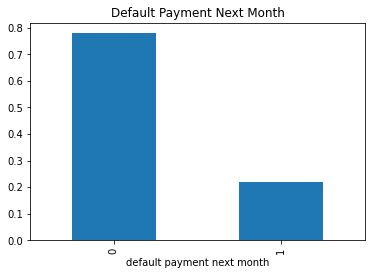

In [4]:
# plot the distribution of the target variable in bar chart
df['default payment next month'].value_counts(normalize=True).plot(kind='bar', title='Default Payment Next Month')
plt.show()

Balance imbalance can be seen.

Process features.

In [5]:
df['MARRIAGE'].value_counts(normalize=True)

MARRIAGE
2    0.532133
1    0.455300
3    0.010767
0    0.001800
Name: proportion, dtype: float64

In [6]:
df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3

In [7]:
df['EDUCATION'].value_counts(normalize=True)

EDUCATION
2    0.467667
1    0.352833
3    0.163900
5    0.009333
4    0.004100
6    0.001700
0    0.000467
Name: proportion, dtype: float64

In [8]:
df.loc[(df['EDUCATION'] > 4) | (df['EDUCATION'] == 0), 'EDUCATION'] = 4

In [9]:
# map the target variable to Yes and No
df['default payment next month'] = df['default payment next month'].map({1: 'Yes', 0: 'No'})

# map the categorical variables to meaningful names and create dummy variables
df['SEX'] = df['SEX'].map({1: 'male', 2: 'female'})
df['EDUCATION'] = df['EDUCATION'].map({1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'})
df['MARRIAGE'] = df['MARRIAGE'].map({1: 'married', 2: 'single', 3: 'others'})
df = pd.get_dummies(df, columns=['SEX'], drop_first=True)
df = pd.get_dummies(df, columns=['EDUCATION'], drop_first=True)
df = pd.get_dummies(df, columns=['MARRIAGE'], drop_first=True)

# delete the ID column
df = df.drop(columns=['ID'])

# # 生成特征交互
# df['EDUCATION_MARRIAGE'] = df['EDUCATION_2'] * df['MARRIAGE_1']
# df['AGE_CREDIT_LIMIT'] = df['AGE'] * df['LIMIT_BAL']
# df['PAY_0_PAY_2'] = df['PAY_0'] * df['PAY_2']
# df['BILL_AMT1_BILL_AMT2'] = df['BILL_AMT1'] * df['BILL_AMT2']
# df['EDUCATION_PAY_0'] = df['EDUCATION_1'] * df['PAY_0']
# df['MARRIAGE_BILL_AMT3'] = df['MARRIAGE_1'] * df['BILL_AMT3']

df.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,SEX_male,EDUCATION_high school,EDUCATION_others,EDUCATION_university,MARRIAGE_others,MARRIAGE_single
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,0,Yes,False,False,False,True,False,False
1,120000,26,-1,2,0,0,0,2,2682,1725,...,1000,0,2000,Yes,False,False,False,True,False,True
2,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,5000,No,False,False,False,True,False,True
3,50000,37,0,0,0,0,0,0,46990,48233,...,1100,1069,1000,No,False,False,False,True,False,False
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,9000,689,679,No,True,False,False,True,False,False


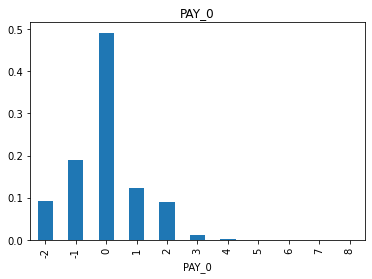

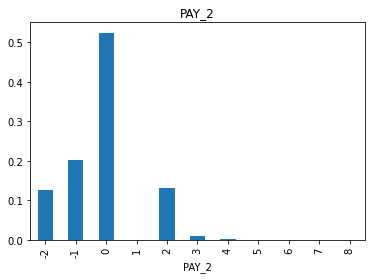

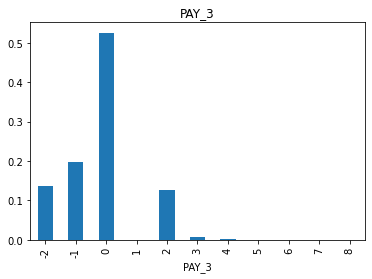

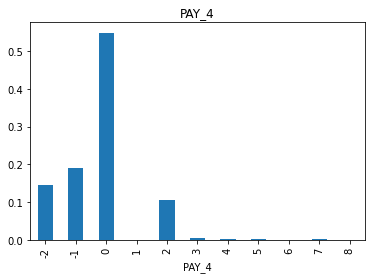

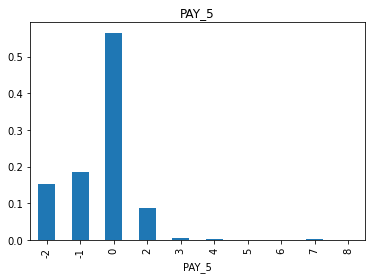

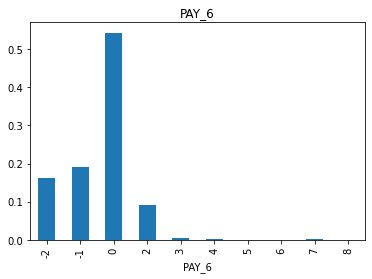

In [10]:
for feature in df.columns:
    # for feature with format PAY_{i}, visualize the distribution of the values
    if feature.startswith('PAY_') and len(feature) < 6:
        df[feature].value_counts(normalize=True).sort_index().plot(kind='bar', title=feature)
        plt.show();

Let's convert payment status lower than 0 to 0 indicating that they were paid duly.

In [11]:
for feature in df.columns:
    # for feature with format PAY_{i}, visualize the distribution of the values
    if feature.startswith('PAY_') and len(feature) < 6:
        df.loc[df[feature] <= 0, feature] = 0

In [12]:
# rename PAY_0 to PAY_6
df = df.rename(columns={'PAY_0': 'PAY_Sep', 'PAY_2': 'PAY_Aug', 'PAY_3': 'PAY_Jul', 'PAY_4': 'PAY_Jun', 'PAY_5': 'PAY_May', 'PAY_6': 'PAY_Apr'})
# rename BILL_AMT1 to BILL_AMT6
df = df.rename(columns={'BILL_AMT1': 'BILL_AMT_Sep', 'BILL_AMT2': 'BILL_AMT_Aug', 'BILL_AMT3': 'BILL_AMT_Jul', 'BILL_AMT4': 'BILL_AMT_Jun', 'BILL_AMT5': 'BILL_AMT_May', 'BILL_AMT6': 'BILL_AMT_Apr'})
# rename PAY_AMT1 to PAY_AMT6
df = df.rename(columns={'PAY_AMT1': 'PAY_AMT_Sep', 'PAY_AMT2': 'PAY_AMT_Aug', 'PAY_AMT3': 'PAY_AMT_Jul', 'PAY_AMT4': 'PAY_AMT_Jun', 'PAY_AMT5': 'PAY_AMT_May', 'PAY_AMT6': 'PAY_AMT_Apr'})
df.head()

,LIMIT_BAL,AGE,PAY_Sep,PAY_Aug,PAY_Jul,PAY_Jun,PAY_May,PAY_Apr,BILL_AMT_Sep,BILL_AMT_Aug,...,PAY_AMT_Jun,PAY_AMT_May,PAY_AMT_Apr,default payment next month,SEX_male,EDUCATION_high school,EDUCATION_others,EDUCATION_university,MARRIAGE_others,MARRIAGE_single
0,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,Yes,False,False,False,True,False,False
1,120000,26,0,2,0,0,0,2,2682,1725,...,1000,0,2000,Yes,False,False,False,True,False,True
2,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,5000,No,False,False,False,True,False,True
3,50000,37,0,0,0,0,0,0,46990,48233,...,1100,1069,1000,No,False,False,False,True,False,False
4,50000,57,0,0,0,0,0,0,8617,5670,...,9000,689,679,No,True,False,False,True,False,False


Correct order of data processing:

1. Train-test split:

	•	First, you should split your dataset into training and test sets to avoid data leakage. The test set should not be used until the very end of the process, to evaluate the model’s generalization performance.

2. SMOTE or sampling to address imbalanced data:

	•	Apply SMOTE or any other resampling technique before scaling or PCA. This ensures the newly generated synthetic data points have meaningful relationships based on the original distribution, without being affected by scaled or PCA-transformed values.

3. Data scaling:

	•	After handling class imbalance, you can scale your data. Scaling is especially important for distance-based algorithms (like PCA or k-NN) and gradient-based optimization.

4. PCA (Principal Component Analysis):

	•	Apply PCA after scaling. PCA is sensitive to different scales in the data, so you should standardize or normalize your features before applying PCA.

In [13]:
# order of data processing pipeline: train_test_split -> sampling_for_imbalanced_data -> data_scaling -> data_pca -> feature_selection
def train_test_split(X, y):
    '''
    Split the data into training and testing sets
    :param X: features
    :param y: target variable
    '''
    # split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def data_scaling(X_train, X_test):
    '''
    Standardize the features
    :param X_train: training features
    :param X_test: testing features
    '''
    # scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def data_pca(X_train, X_test, n_components):
    '''
    Apply PCA to reduce the dimensionality of the data
    :param X_train: training features
    :param X_test: testing features
    '''
    # apply PCA to reduce the dimensionality of the data
    # if n_components is an integer, return the first n components
    # if 0 < n_components < 1, return the number of components required to explain the variance specified by n_components
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

def sampling_for_imbalanced_data(X_train, y_train):
    '''
    Apply over-sampling or under-sampling to balance the target variable
    :param X_train: training features
    :param y_train: target variable
    '''
    # apply over-sampling or under-sampling to balance the target variable
    from imblearn.over_sampling import SMOTE
    # check the distribution of the target variable
    unique, counts = np.unique(y_train, return_counts=True)
    print('Applying SMOTE to balance the target variable...')
    print(dict(zip(unique, counts)))
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # check the distribution of the target variable after resampling
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    print('After applying SMOTE...')
    print(dict(zip(unique, counts)))
    return X_train_resampled, y_train_resampled

In [14]:
def get_train_test_data(df, target_variable='default payment next month', sampling=False, pca_n_components=None):
    '''
    Prepare the training and testing data
    :param df: dataframe
    :param target_variable: target variable
    :param pca_n_components: if pca_n_components is an integer, return the first n components; if 0 < pca_n_components < 1, return the number of components required to explain the variance specified by pca_n_components
    '''
    # split the data into features and target variable
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    if sampling:
        # apply over-sampling or under-sampling to balance the target variable
        X_train, y_train = sampling_for_imbalanced_data(X_train, y_train)
    # scale the data
    X_train_scaled, X_test_scaled = data_scaling(X_train, X_test)
    if pca_n_components:
        # apply PCA to reduce the dimensionality of the data
        X_train_scaled, X_test_scaled = data_pca(X_train_scaled, X_test_scaled, n_components=pca_n_components)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [15]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, balanced_accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

def eval_best_model(df, model, param_grid, scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=None, target_to_num=False):
    '''
    Evaluate the best model
    :param df: dataframe
    :param model: machine learning model
    :param param_grid: hyperparameter grid
    :param scoring: scoring method
    :param target_variable: target variable
    :param sampling: apply over-sampling or under-sampling to balance the target variable
    :param pca_n_components: if pca_n_components is an integer, return the first n components; if 0 < pca_n_components < 1, return the number of components required to explain the variance specified by pca_n_components
    :param target_to_num: convert binary target variable to numerical values
    '''
    # prepare the training and testing data
    X_train, X_test, y_train, y_test = get_train_test_data(df, target_variable=target_variable, sampling=sampling, pca_n_components=pca_n_components)
    # convert binary target variable to numerical values
    target_to_num = {'No': 0, 'Yes': 1}
    y_train = y_train.map(target_to_num)
    y_test = y_test.map(target_to_num)
    # cross-validation and hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, verbose=1, n_jobs=-1)
    # Fit the grid search on the training data
    grid_search.fit(X_train, y_train)
    # Best parameters and best estimator
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation balanced accuracy: {grid_search.best_score_}")
    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    # print several metrics to evaluate the model including balanced accuracy, accuracy
    print(f"Test balanced accuracy: {test_balanced_accuracy}, Test accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_model, X_train, X_test, y_train, y_test

#### Logistic regression

L1 (Lasso) and L2 (Ridge) regularization are techniques used to prevent overfitting and improve the generalization of machine learning models. Each one imposes a penalty on the magnitude of the coefficients (weights) of the model but in different ways. Here’s when to use L1 vs. L2 regularization:

L1 Regularization (Lasso)

	•	How it works: L1 regularization adds a penalty that is proportional to the absolute values of the coefficients. The loss function for L1 includes a term proportional to the sum of the absolute values of the model’s coefficients.
 L(\theta) = Loss + \lambda \sum_{i} |\theta_i| 
Where:
	•	 \lambda  is the regularization strength (higher values penalize larger weights more).
	•	 \theta_i  are the model parameters (weights).
	•	Effect: L1 regularization tends to shrink some coefficients to exactly zero, which means it performs feature selection. It forces the model to focus on a subset of important features, making it useful when you have a large number of features, and you suspect that only a small subset of them are significant.
	•	When to use L1:
	•	When you suspect that only a few features are important.
	•	When you want to perform feature selection automatically.
	•	When dealing with high-dimensional data where feature selection is necessary (e.g., text data with many features).
	•	Example: Logistic regression with sparse data, like text classification or gene selection in bioinformatics, where you expect many features to be irrelevant.

L2 Regularization (Ridge)

	•	How it works: L2 regularization adds a penalty proportional to the squared values of the coefficients. The loss function includes a term proportional to the sum of the squared values of the coefficients.
 L(\theta) = Loss + \lambda \sum_{i} \theta_i^2 
Where:
	•	 \lambda  is the regularization strength.
	•	 \theta_i  are the model parameters (weights).
	•	Effect: L2 regularization tends to shrink the coefficients uniformly, but it doesn’t force them to be exactly zero. This means all features are kept in the model, but their impact is reduced. It leads to a more stable and less sensitive model by distributing the penalty across all features.
	•	When to use L2:
	•	When you believe all features are important, but you want to reduce their influence and avoid overfitting.
	•	When you have collinear features (features that are highly correlated).
	•	When the model is more sensitive to noisy data and you want to make the model more stable.
	•	Example: Linear regression problems where all features are thought to contribute, such as predicting house prices where each feature has some importance but might vary in magnitude.

L1 vs. L2 Trade-offs

	•	L1 (Lasso):
	•	Good for sparse models (feature selection).
	•	Can lead to some coefficients being zero (removing irrelevant features).
	•	Might be less stable when dealing with multicollinearity (high correlation between features).
	•	L2 (Ridge):
	•	Keeps all features but shrinks them, making it more robust for cases with multicollinearity.
	•	Doesn’t perform feature selection, but makes the model less sensitive to outliers.
	•	More stable when dealing with a large number of features with some noise.

Balanced accuracy is the average of recall scores for each class, which helps to account for class imbalance by giving equal weight to both the majority and minority classes.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation balanced accuracy: 0.7019238362696676
Test balanced accuracy: 0.7029759031113103, Test accuracy: 0.7775
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4687
           1       0.49      0.57      0.53      1313

    accuracy                           0.78      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000



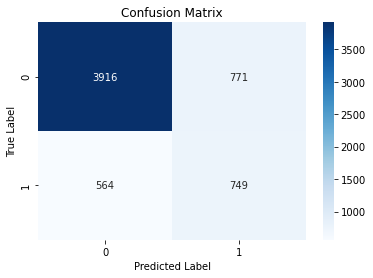

In [16]:
from sklearn.linear_model import LogisticRegression

# use logistic regression with class_weight='balanced'
model = LogisticRegression(max_iter=2000, random_state=42)
# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],             # Type of regularization (L1 or L2)
    'C': [0.01, 0.1, 1, 10, 100],        # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],      # Solvers that support L1 and L2 regularization
    'class_weight': ['balanced', None],   # Option to handle class imbalance
}

best_lr_model, X_train, X_test, y_train, y_test = eval_best_model(df, model, param_grid, scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=None)

1. C: 0.01 (Inverse of Regularization Strength)

	•	C controls the regularization strength in logistic regression. A smaller C value means stronger regularization (i.e., the model is more constrained and avoids overfitting). In your case, C=0.01 suggests that the model benefits from strong regularization to prevent overfitting, which can often occur in small datasets or imbalanced datasets.
	•	Stronger regularization with a small C helps the model to generalize better, especially when the data has some noise or imbalance, as it prevents the model from becoming too complex and overfitting to the majority class.

2. class_weight: ‘balanced’

	•	class_weight='balanced' automatically adjusts the weights of the classes based on their frequency in the dataset. For imbalanced datasets (like yours), this ensures that the minority class is not under-represented during the model training.
	•	In your case, the label distribution is imbalanced, so 'class_weight': 'balanced' helps the model treat both the majority and minority classes more equally. Without this, the model might heavily favor the majority class, leading to poor performance on the minority class.

3. penalty: ‘l2’ (Ridge Regularization)

	•	penalty='l2' refers to L2 regularization, also known as Ridge regularization. It penalizes the sum of the squared coefficients and helps prevent overfitting by shrinking the coefficients. L2 regularization generally leads to better results when the dataset contains noisy features or collinearity among features.
	•	Compared to L1 regularization (which enforces sparsity by shrinking some coefficients to zero), L2 is more appropriate when most features are important, and the dataset doesn’t need to perform feature selection via regularization. The grid search might have found that L2 penalty works better for your dataset than L1.

4. solver: ‘saga’

	•	saga is a solver that supports both L1 and L2 penalties and is efficient for large datasets. It’s a variation of the sag solver and is faster for large datasets with a lot of features. It also works well for imbalanced datasets, especially when used with regularization.
	•	The saga solver can handle both the L1 and L2 penalties efficiently and is particularly well-suited for logistic regression with larger datasets or when working with class_weight='balanced'. It was likely chosen because it supports the chosen L2 penalty and can converge well even with the balanced class weights.
	(liblinear: A solver that is good for smaller datasets and binary classification problems)

#### Try using SMOTE 

Applying SMOTE to balance the target variable...
{'No': 18677, 'Yes': 5323}
After applying SMOTE...
{'No': 18677, 'Yes': 18677}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation balanced accuracy: 0.739006439749003
Test balanced accuracy: 0.6631565554349661, Test accuracy: 0.72
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      4687
           1       0.40      0.56      0.47      1313

    accuracy                           0.72      6000
   macro avg       0.63      0.66      0.64      6000
weighted avg       0.76      0.72      0.74      6000



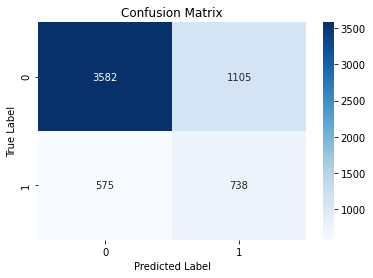

In [17]:
# use logistic regression with class_weight='balanced'
model = LogisticRegression(max_iter=2000, random_state=42)
# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],             # Type of regularization (L1 or L2)
    'C': [0.01, 0.1, 1, 10, 100],        # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],      # Solvers that support L1 and L2 regularization
    'class_weight': ['balanced', None],   # Option to handle class imbalance
}

best_model, _, _, _, _ = eval_best_model(df, model, param_grid, scoring='balanced_accuracy', target_variable='default payment next month', sampling=True, pca_n_components=None)

Worse performance!

Using SMOTE (Synthetic Minority Over-sampling Technique) in conjunction with a class_weight='balanced' parameter in logistic regression can sometimes yield worse performance due to several factors. Here’s an explanation of why this may occur:

1. Overfitting to Synthetic Samples

	•	SMOTE creates synthetic instances of the minority class by interpolating between existing instances. This can lead to a model that overfits to these synthetic data points, especially if the minority class is highly irregular or noisy. As a result, the model may perform poorly on unseen data because it has learned patterns that do not generalize well.

2. Redundant Information

	•	Class weighting inherently addresses class imbalance by giving more importance to the minority class during training. When you combine this with SMOTE, you may end up introducing redundancy, where the model learns from both the synthetic samples and the increased weight on the actual minority class samples. This can lead to confusion during training.

3. Bias from Synthetic Samples

	•	The synthetic samples generated by SMOTE may not represent the true distribution of the minority class. If the synthetic data points introduce bias or noise that does not reflect real-world scenarios, the model can learn ineffective decision boundaries, leading to worse predictive performance.


#### Using PCA

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation balanced accuracy: 0.7009016227344601
Test balanced accuracy: 0.6979064616346586, Test accuracy: 0.782
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4687
           1       0.50      0.55      0.52      1313

    accuracy                           0.78      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.78      0.79      6000



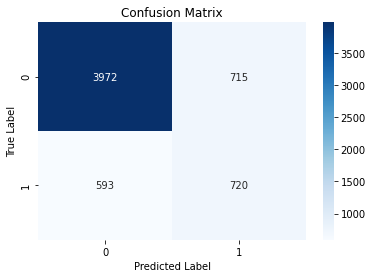

In [18]:
# use logistic regression with class_weight='balanced'
model = LogisticRegression(max_iter=2000, random_state=42)
# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],             # Type of regularization (L1 or L2)
    'C': [0.01, 0.1, 1, 10, 100],        # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],      # Solvers that support L1 and L2 regularization
    'class_weight': ['balanced', None],   # Option to handle class imbalance
}

best_model, _, _, _, _  = eval_best_model(df, model, param_grid, scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=0.9)

Similar performance. 

In [19]:
def plot_logreg_feature_importance(model, feature_names):
    """
    This function takes a trained logistic regression model and a list of feature names,
    and returns a DataFrame of sorted feature importance based on model coefficients.
    It also plots the feature importance as a horizontal bar plot.

    Parameters:
    model : Trained logistic regression model (e.g., sklearn.linear_model.LogisticRegression)
    feature_names : List of feature names corresponding to the input data

    Returns:
    feature_importance : DataFrame containing feature names and their importance, sorted by importance
    """
    # Extract the coefficients from the model
    coefficients = model.coef_[0]  # For binary classification

    # Create a DataFrame of feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefficients)  # Take the absolute value for ranking
    })

    # Sort the DataFrame by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance (Logistic Regression)')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

    return feature_importance

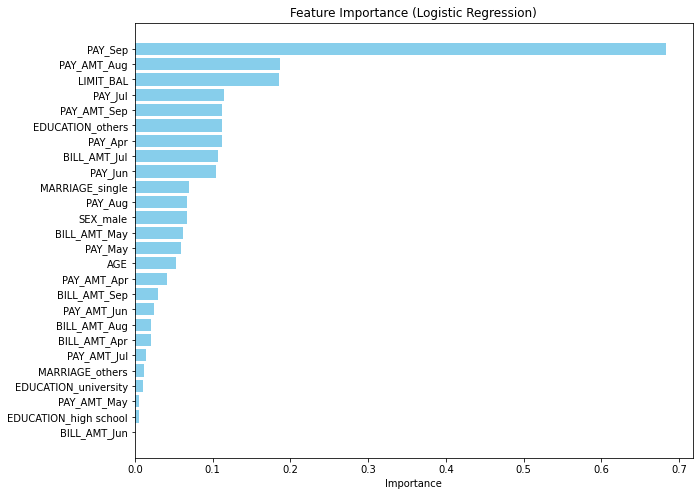

In [20]:
# plot the feature importance
feature_importance = plot_logreg_feature_importance(best_lr_model, df.drop(columns='default payment next month').columns)

In [21]:
from sklearn.inspection import PartialDependenceDisplay

def plot_partial_dependence(model, X_train, top_features, feature_names, model_name):
    """
    Plots the partial dependence of the top N important features from the trained logistic regression model.

    Parameters:
    - model: Trained logistic regression model
    - X_train: Training feature data (DataFrame or array)
    - top_features: List of top N important features
    - feature_names: List of the feature names of all features
    - model_name: Name of the model
    """
    # Plotting Partial Dependence
    fig, ax = plt.subplots(figsize=(15, 10))
    PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        features=top_features,
        ax=ax,
        grid_resolution=50,
        feature_names=feature_names
    )
    plt.suptitle(f'Partial Dependence Plots for the Top Features Using {model_name}', fontsize=16)
    plt.show()

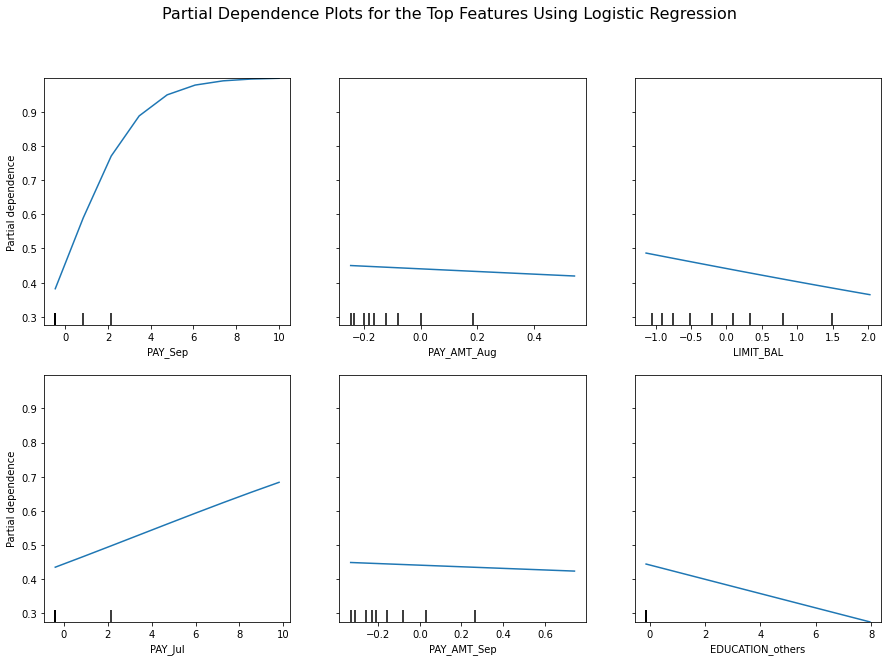

In [22]:
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(6)['Feature'].tolist()
# plot the partial dependence of the top 6 important features
plot_partial_dependence(best_lr_model, X_train, top_features, df.drop(columns='default payment next month').columns, 'Logistic Regression')

We can see when the values of PAY_AMT_Sep, LIMIT_BAL, BILL_AMT_Jul, and Education_others increases, the likelihood of defaulting also increases.

When values of PAY_Sep increases, the likelihood of defaulting also decreases.

Intepretation:

Positive Relationship with PAY_AMT_Sep, LIMIT_BAL, BILL_AMT_Jul, and Education_others:

1. PAY_AMT_Sep

	•	Observation: When values of PAY_AMT_Sep increase, the likelihood of defaulting also increases.

	•	Interpretation: This is somewhat counterintuitive since one would typically expect that higher payments reduce the risk of default. However, if the values of PAY_AMT_Sep are high, it could imply that clients are facing challenges managing their credit, potentially resulting in larger payments being required to keep up with debts, which could also reflect financial stress.

2. LIMIT_BAL

	•	Observation: As LIMIT_BAL increases, the likelihood of defaulting also increases.

	•	Interpretation: This could suggest that higher credit limits may lead to increased spending, which can create a heavier financial burden. Clients with high limits might accumulate more debt and thus become more likely to default if they struggle to manage their repayment obligations. It might also indicate that lenders are extending credit to individuals who are already in a precarious financial position.

3. BILL_AMT_Jul

	•	Observation: Higher values of BILL_AMT_Jul lead to an increased likelihood of defaulting.

	•	Interpretation: A higher bill amount indicates that the client is spending more on their credit card, which may signify financial strain. If clients cannot manage their expenditures, they may struggle to make timely payments, leading to defaults.

4. Education_others

	•	Observation: When the values for this feature increase, the likelihood of defaulting also rises.

	•	Interpretation: Clients classified under the “Education_others” category may have varying financial literacy or stability. If this group includes individuals with less conventional educational backgrounds, they may be more prone to mismanaging their credit and defaulting on payments.

Negative Relationship with PAY_Sep (Repayment Status)

1. PAY_Sep

	•	Observation: When the values of PAY_Sep increase, the likelihood of defaulting decreases.

	•	Interpretation: As the repayment status in September increases (indicating more months of payment delays), the likelihood of defaulting decreases slightly.
	
	•	Potential Implications:
	- Diligent Payments Despite Delays: A higher value for PAY_Sep indicates increasing delays. However, if the likelihood of defaulting decreases, it could suggest that clients who have experienced payment delays are still managing to maintain their accounts without defaulting.
	- Financial Recovery: Clients who have experienced some payment delays may eventually stabilize their financial situation, leading to a reduced likelihood of default.
	- Behavioral Patterns: It might also indicate that clients with delayed payments are making efforts to repay their debts, possibly showing a willingness to resolve their payment issues over time.

### AdaBoost

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'algorithm': 'SAMME', 'learning_rate': 0.005, 'n_estimators': 50}
Best cross-validation balanced accuracy: 0.6447748422753916
Test balanced accuracy: 0.6390153055777588, Test accuracy: 0.8193333333333334
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4687
           1       0.69      0.32      0.44      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000



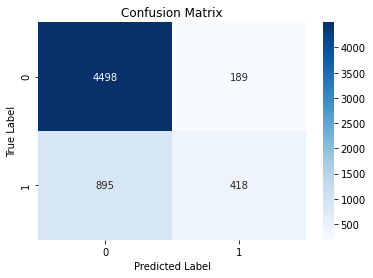

In [23]:
from sklearn.ensemble import AdaBoostClassifier

# use AdaBoostClassifier
model = AdaBoostClassifier(random_state=42)
# define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'learning_rate': [0.005, 0.01, 0.02, 0.1],         # Learning rate shrinks the contribution of each classifier
    'algorithm': ['SAMME', 'SAMME.R'],        # If 'SAMME.R' then use the probability estimates in the update
}
best_ada_model, _, _, _, _ = eval_best_model(df, model, param_grid, scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=None)

In [24]:
def plot_feature_importance(model, feature_names):
    """
    This function takes a trained sklearn model and a list of feature names,
    and returns a DataFrame of sorted feature importance based on model coefficients.
    It also plots the feature importance as a horizontal bar plot.

    Parameters:
    model : Trained sklearn model (e.g., sklearn.ensemble.RandomForestClassifier)
    feature_names : List of feature names corresponding to the input data

    Returns:
    feature_importance : DataFrame containing feature names and their importance, sorted by importance
    """
    # Create a DataFrame of feature importance
    feature_importance = pd.DataFrame({
      'Feature': feature_names,
      'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance (Logistic Regression)')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

    return feature_importance

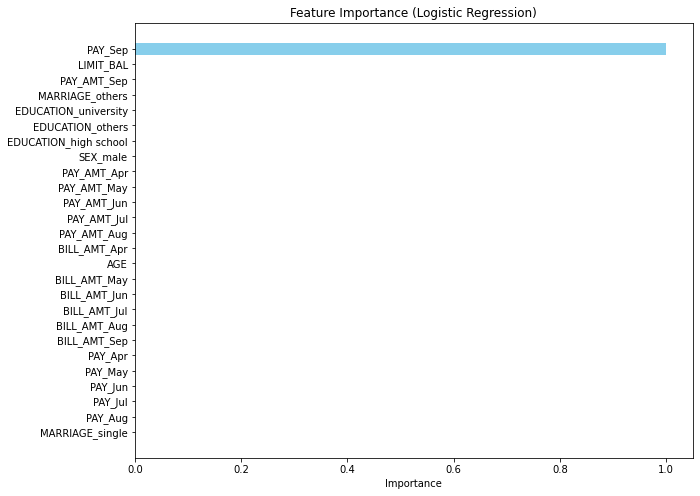

In [25]:
feature_importance = plot_feature_importance(best_ada_model, df.drop(columns='default payment next month').columns)

When a model’s feature importance indicates that only one feature has an importance score of 1 while all other features have an importance score of 0, it usually suggests overfitting - the model may be overfitting to that single feature. This often happens in models that are too complex or when there are not enough samples to capture the underlying patterns in the data. If the model has memorized the training data rather than learned generalizable patterns, it may rely heavily on one feature.

#### Try SMOTE

Applying SMOTE to balance the target variable...
{'No': 18677, 'Yes': 5323}
After applying SMOTE...
{'No': 18677, 'Yes': 18677}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation balanced accuracy: 0.7509732362712807
Test balanced accuracy: 0.6815982889913944, Test accuracy: 0.7526666666666667
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4687
           1       0.45      0.56      0.50      1313

    accuracy                           0.75      6000
   macro avg       0.66      0.68      0.67      6000
weighted avg       0.77      0.75      0.76      6000



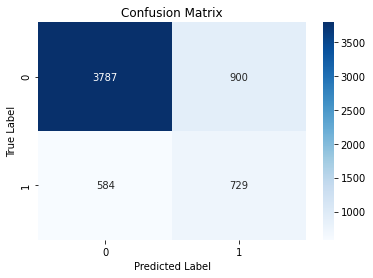

In [26]:
# use AdaBoostClassifier
model = AdaBoostClassifier(random_state=42)
# define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'learning_rate': [0.005, 0.01, 0.02, 0.1],         # Learning rate shrinks the contribution of each classifier
    'algorithm': ['SAMME', 'SAMME.R'],        # If 'SAMME.R' then use the probability estimates in the update
}
best_model, _, _, _, _ = eval_best_model(df, model, param_grid, scoring='balanced_accuracy', target_variable='default payment next month', sampling=True, pca_n_components=None)

SMOTE can slightly increase the performance on the f1-score of 'Yes' class.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'algorithm': 'SAMME.R', 'learning_rate': 0.005, 'n_estimators': 100}
Best cross-validation balanced accuracy: 0.6543570953702273
Test balanced accuracy: 0.6572972251845985, Test accuracy: 0.7995
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4687
           1       0.56      0.40      0.47      1313

    accuracy                           0.80      6000
   macro avg       0.70      0.66      0.67      6000
weighted avg       0.78      0.80      0.79      6000



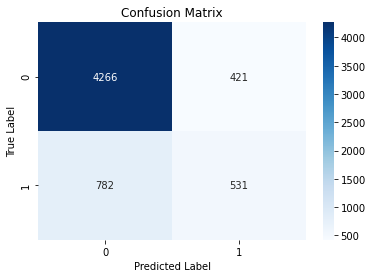

In [27]:
# use AdaBoostClassifier
model = AdaBoostClassifier(random_state=42)
# define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'learning_rate': [0.005, 0.01, 0.02, 0.1],         # Learning rate shrinks the contribution of each classifier
    'algorithm': ['SAMME', 'SAMME.R'],        # If 'SAMME.R' then use the probability estimates in the update
}
best_model, _, _, _, _ = eval_best_model(df, model, param_grid, scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=0.9)

PCA did not improve the performance either.

In summary, AdaBoost did not outperform logistic regression.

### Decision Tree

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation balanced accuracy: 0.6582039240503725
Test balanced accuracy: 0.6567270298118421, Test accuracy: 0.8191666666666667
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.65      0.37      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



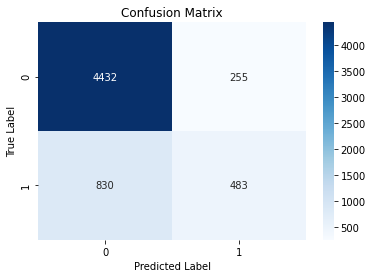

In [28]:
from sklearn.tree import DecisionTreeClassifier
# use DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
# define the hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],          # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}
best_dt_model, _, _, _, _ = eval_best_model(df, model, param_grid=param_grid,
                                scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=None)

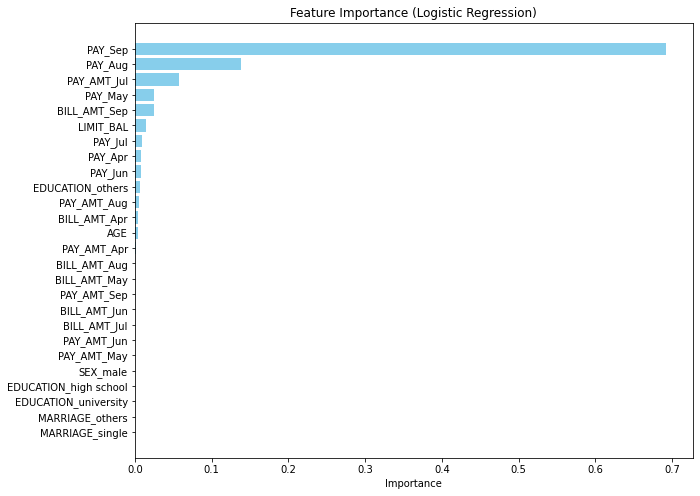

In [29]:
feature_importance = plot_feature_importance(best_dt_model, df.drop(columns='default payment next month').columns)

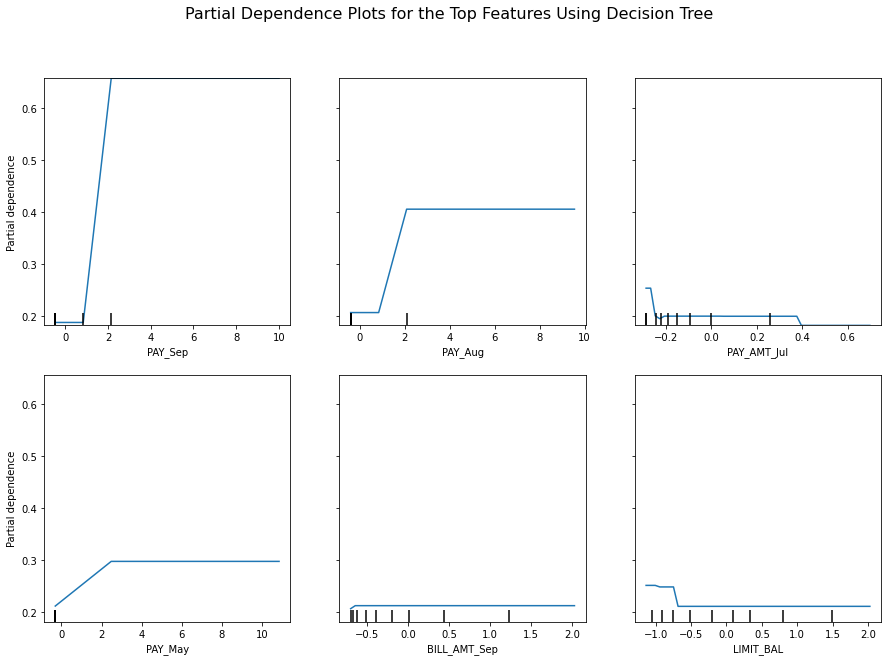

In [30]:
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(6)['Feature'].tolist()
plot_partial_dependence(best_dt_model, X_train, top_features, df.drop(columns='default payment next month').columns, 'Decision Tree')

### Random Forest

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best cross-validation balanced accuracy: 0.6594850436527624
Test balanced accuracy: 0.6566352200695772, Test accuracy: 0.8181666666666667
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.65      0.37      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



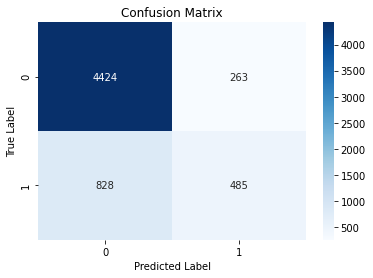

In [31]:
from sklearn.ensemble import RandomForestClassifier

# use RandomForestClassifier
model = RandomForestClassifier(random_state=42)
# define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [5, 10, 20, 30],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 10]        # Minimum number of samples required to be at a leaf node
}
best_rf_model, _, _, _, _ = eval_best_model(df, model, param_grid=param_grid,
                                scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=None)

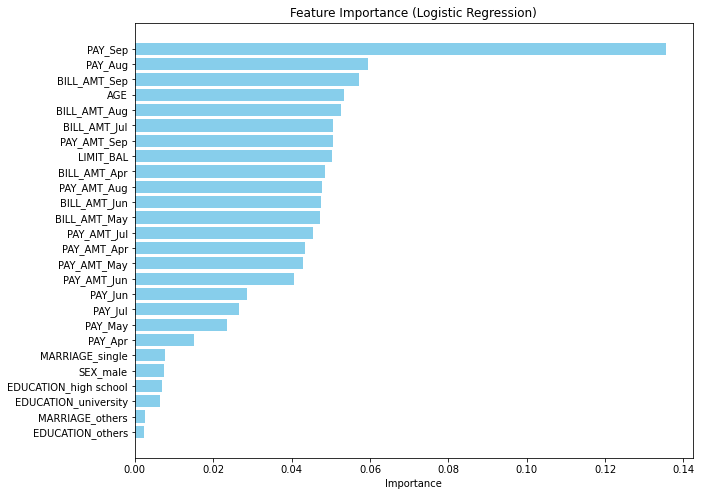

In [32]:
feature_importance = plot_feature_importance(best_rf_model, df.drop(columns='default payment next month').columns)

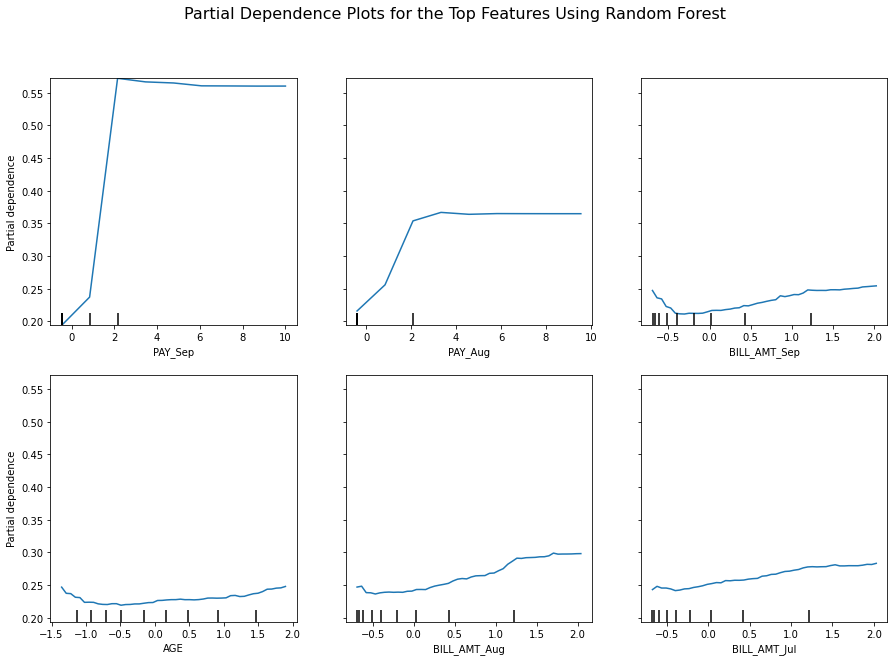

In [33]:
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(6)['Feature'].tolist()
plot_partial_dependence(best_rf_model, X_train, top_features, df.drop(columns='default payment next month').columns, 'Random Forest')

### Gradient Boosting

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation balanced accuracy: 0.6604730265768293
Test balanced accuracy: 0.6528433152189191, Test accuracy: 0.8186666666666667
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.66      0.36      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



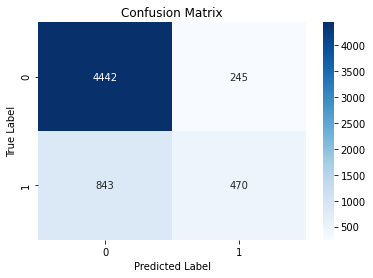

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# use GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42)
# define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'learning_rate': [0.005, 0.01, 0.02, 0.1],         # Learning rate shrinks the contribution of each classifier
    'max_depth': [3, 5, 10],                  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]             # Minimum number of samples required to be at a leaf node
}
best_gb_model, _, _, _, _ = eval_best_model(df, model, param_grid=param_grid,
                                scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=None)

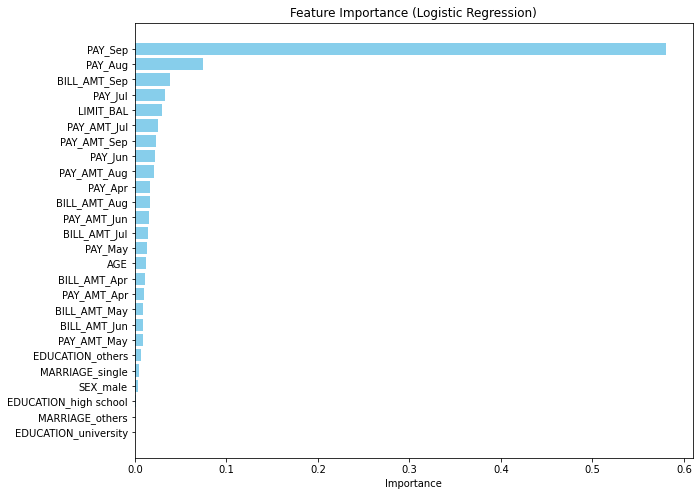

In [35]:
feature_importance = plot_feature_importance(best_gb_model, df.drop(columns='default payment next month').columns)

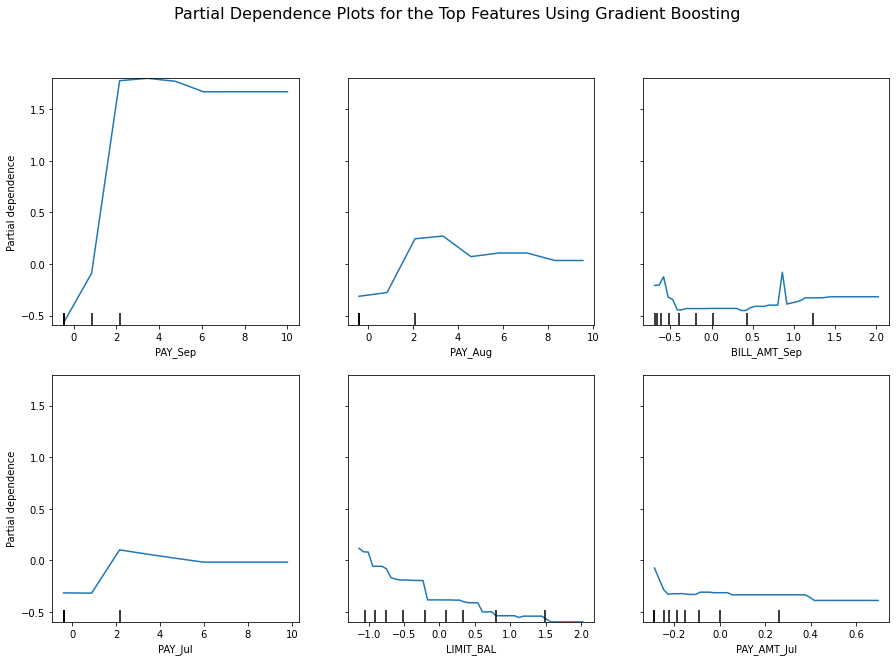

In [36]:
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(6)['Feature'].tolist()
plot_partial_dependence(best_gb_model, X_train, top_features, df.drop(columns='default payment next month').columns, 'Gradient Boosting')

### XGBoost

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation balanced accuracy: 0.656350844483184
Test balanced accuracy: 0.6519304176400802, Test accuracy: 0.8206666666666667
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



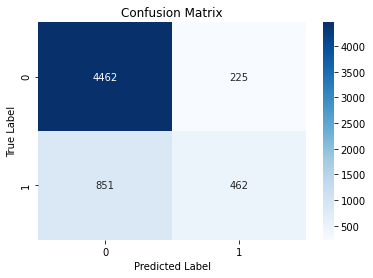

In [37]:
import xgboost as xgb
# use XGBClassifier
model = xgb.XGBClassifier(random_state=42)
# define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],           # Number of trees in the forest
    'learning_rate': [0.005, 0.01, 0.02],     # Learning rate shrinks the contribution of each classifier
    'max_depth': [3, 5, 10],                  # Maximum depth of the tree
    'min_child_weight': [1, 2, 4],            # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 1.0],                  # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0],           # Subsample ratio of columns when constructing each tree
}
best_xgb_model, X_train, X_test, y_train, y_test = eval_best_model(df, model, param_grid=param_grid,
                                scoring='balanced_accuracy', target_variable='default payment next month', sampling=False, pca_n_components=None,
                                target_to_num=True)

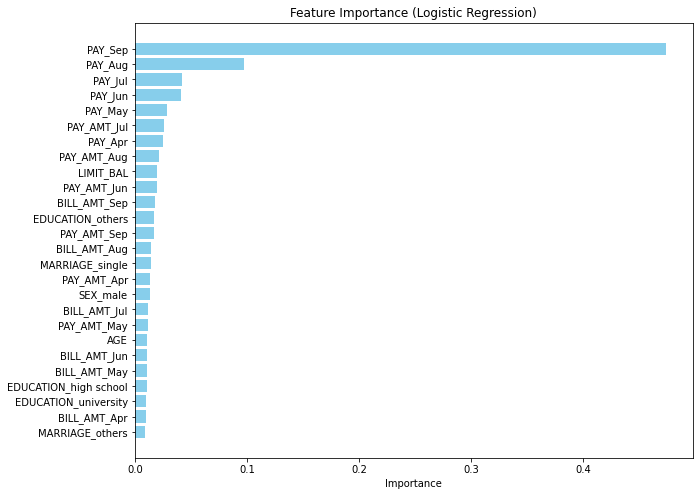

In [38]:
feature_importance = plot_feature_importance(best_xgb_model, df.drop(columns='default payment next month').columns)

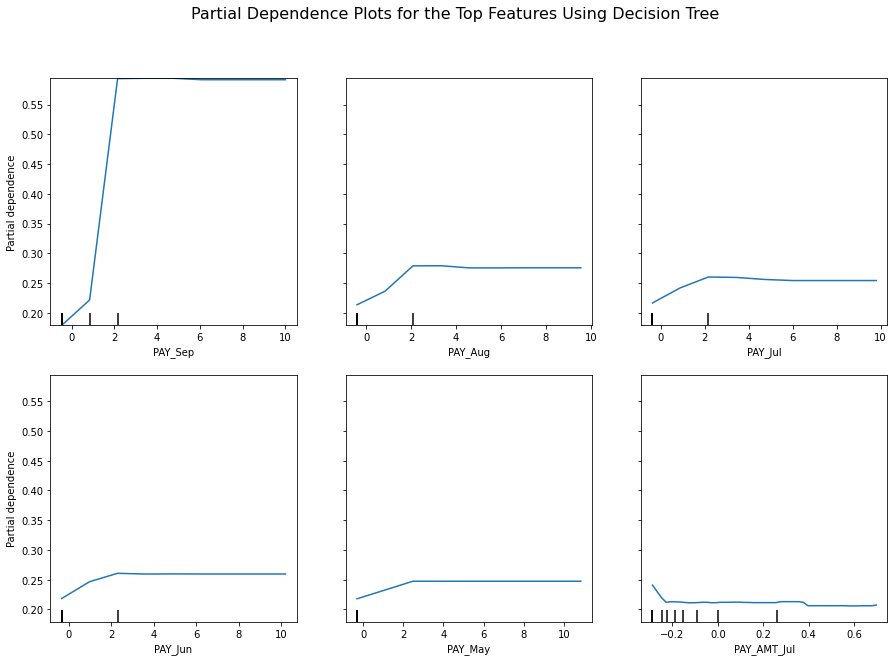

In [39]:
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(6)['Feature'].tolist()
plot_partial_dependence(best_xgb_model, X_train, top_features, df.drop(columns='default payment next month').columns, 'Decision Tree')

In [40]:
from sklearn.inspection import PartialDependenceDisplay

def plot_partial_dependence_comparison(models, model_names, X_train, features, feature_names):
    """
    Plots the partial dependence of the given features from multiple trained models, with each model-feature
    combination displayed in separate subplots.

    Each column represents a feature, and each row represents a model, with subplots arranged accordingly.

    Parameters:
    - models: List of trained models
    - model_names: List of model names corresponding to the models
    - X_train: Training feature data (DataFrame or array)
    - features: List of feature indices or column names to plot
    - feature_names: List of the feature names for labeling the axes
    """
    # Number of features and models
    num_features = len(features)
    num_models = len(models)

    # Create a grid of subplots (num_models rows, num_features columns)
    fig, axes = plt.subplots(nrows=num_models, ncols=num_features, figsize=(6 * num_features, 6 * num_models), constrained_layout=False)

    # If there's only one model or feature, axes won't be an array, so we convert them to an array
    if num_models == 1:
        axes = [axes]  # Convert to list for uniformity
    if num_features == 1:
        axes = [[ax] for ax in axes]  # Convert to 2D list for uniformity

    # Loop through each feature and each model to create the partial dependence plots
    for i, feature in enumerate(features):  # Loop through features (columns)
        for j, (model, model_name) in enumerate(zip(models, model_names)):  # Loop through models (rows)
            ax = axes[j][i]  # Select the corresponding subplot
            disp = PartialDependenceDisplay.from_estimator(
                model,
                X_train,
                features=[feature],
                ax=ax,
                grid_resolution=50,
                feature_names=feature_names
            )
            # Set the subtitle for each plot
            ax.set_title(f'Model: {model_name} | Feature: {feature}')

    # Set a common title for the entire figure
    plt.suptitle('Partial Dependence Plots Comparison', fontsize=16)
    plt.show()

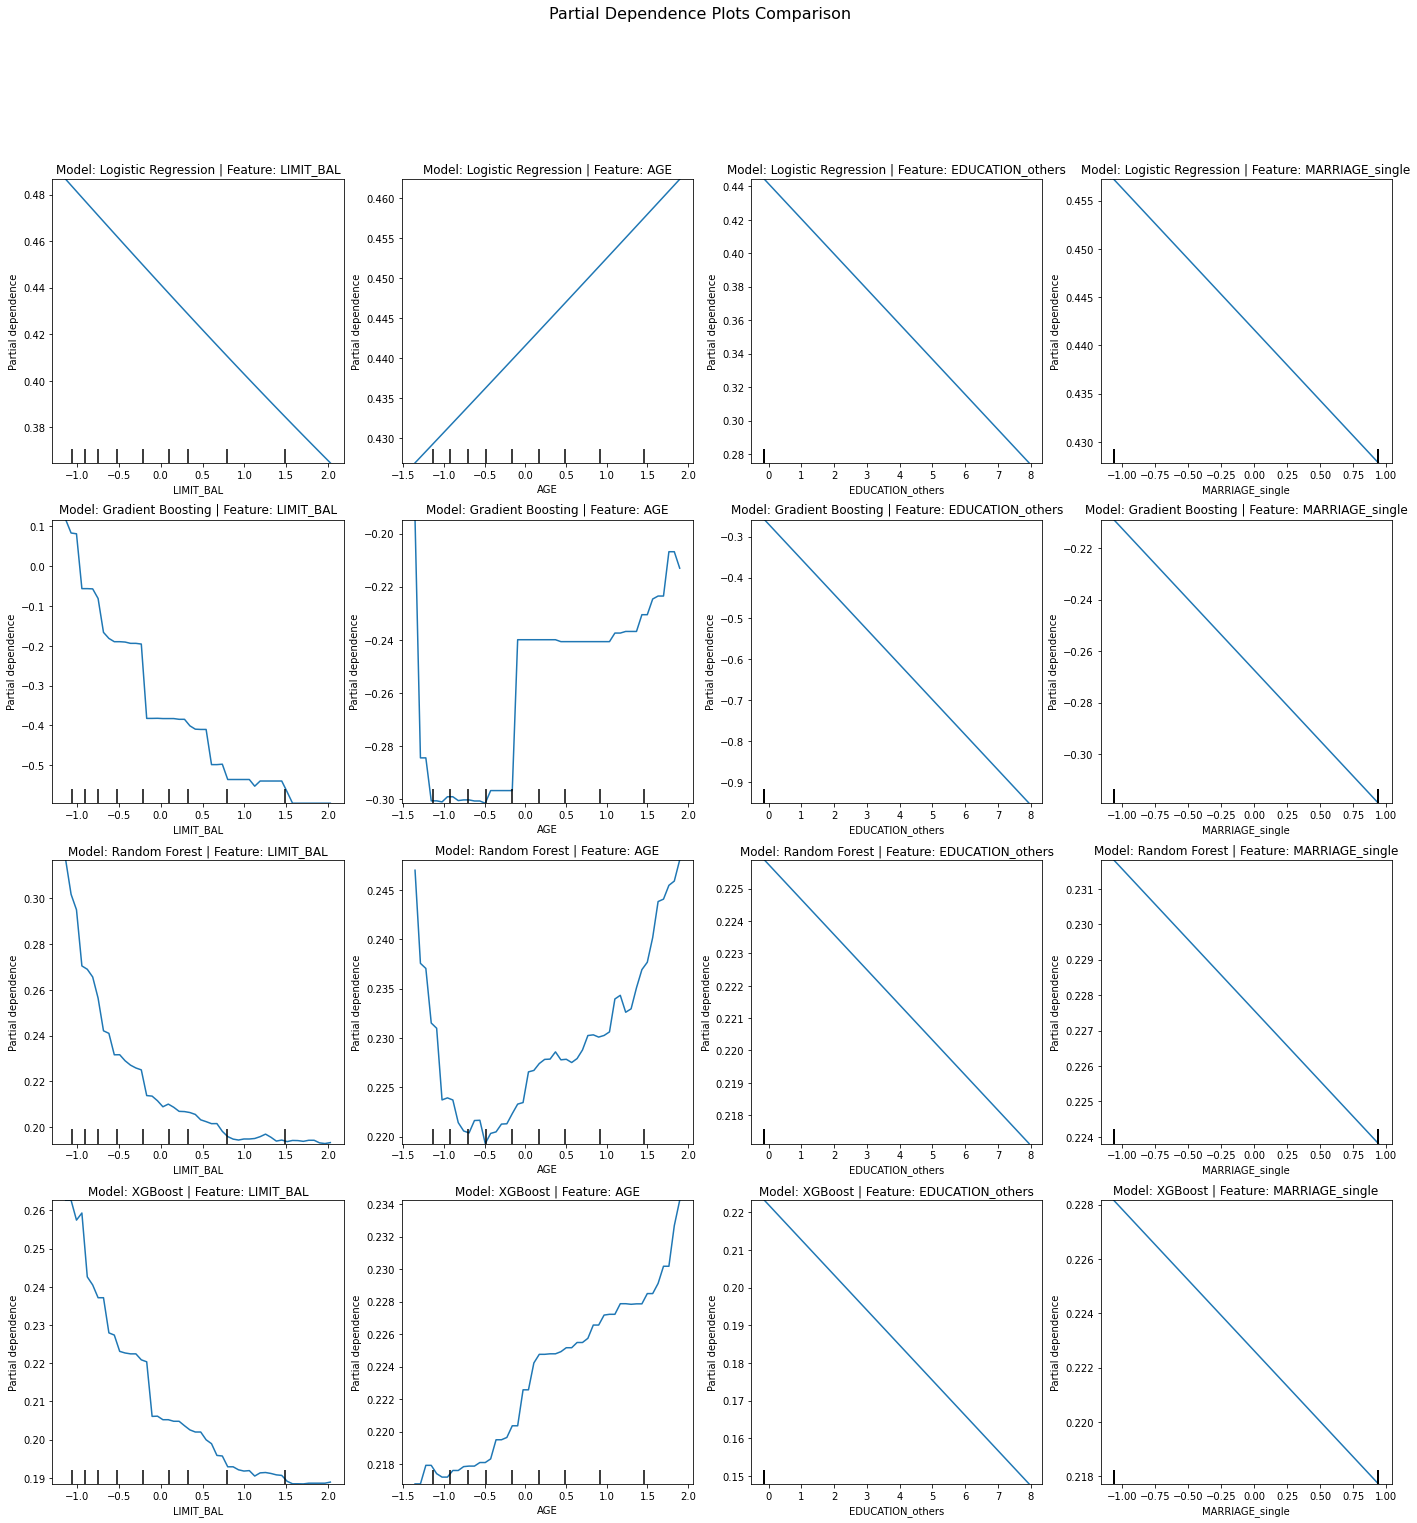

In [41]:
features = ['LIMIT_BAL', 'AGE', 'EDUCATION_others', 'MARRIAGE_single']
models = [best_lr_model, best_gb_model, best_rf_model, best_xgb_model]
model_names = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'XGBoost']
plot_partial_dependence_comparison(models, model_names, X_train, features, df.drop(columns='default payment next month').columns)

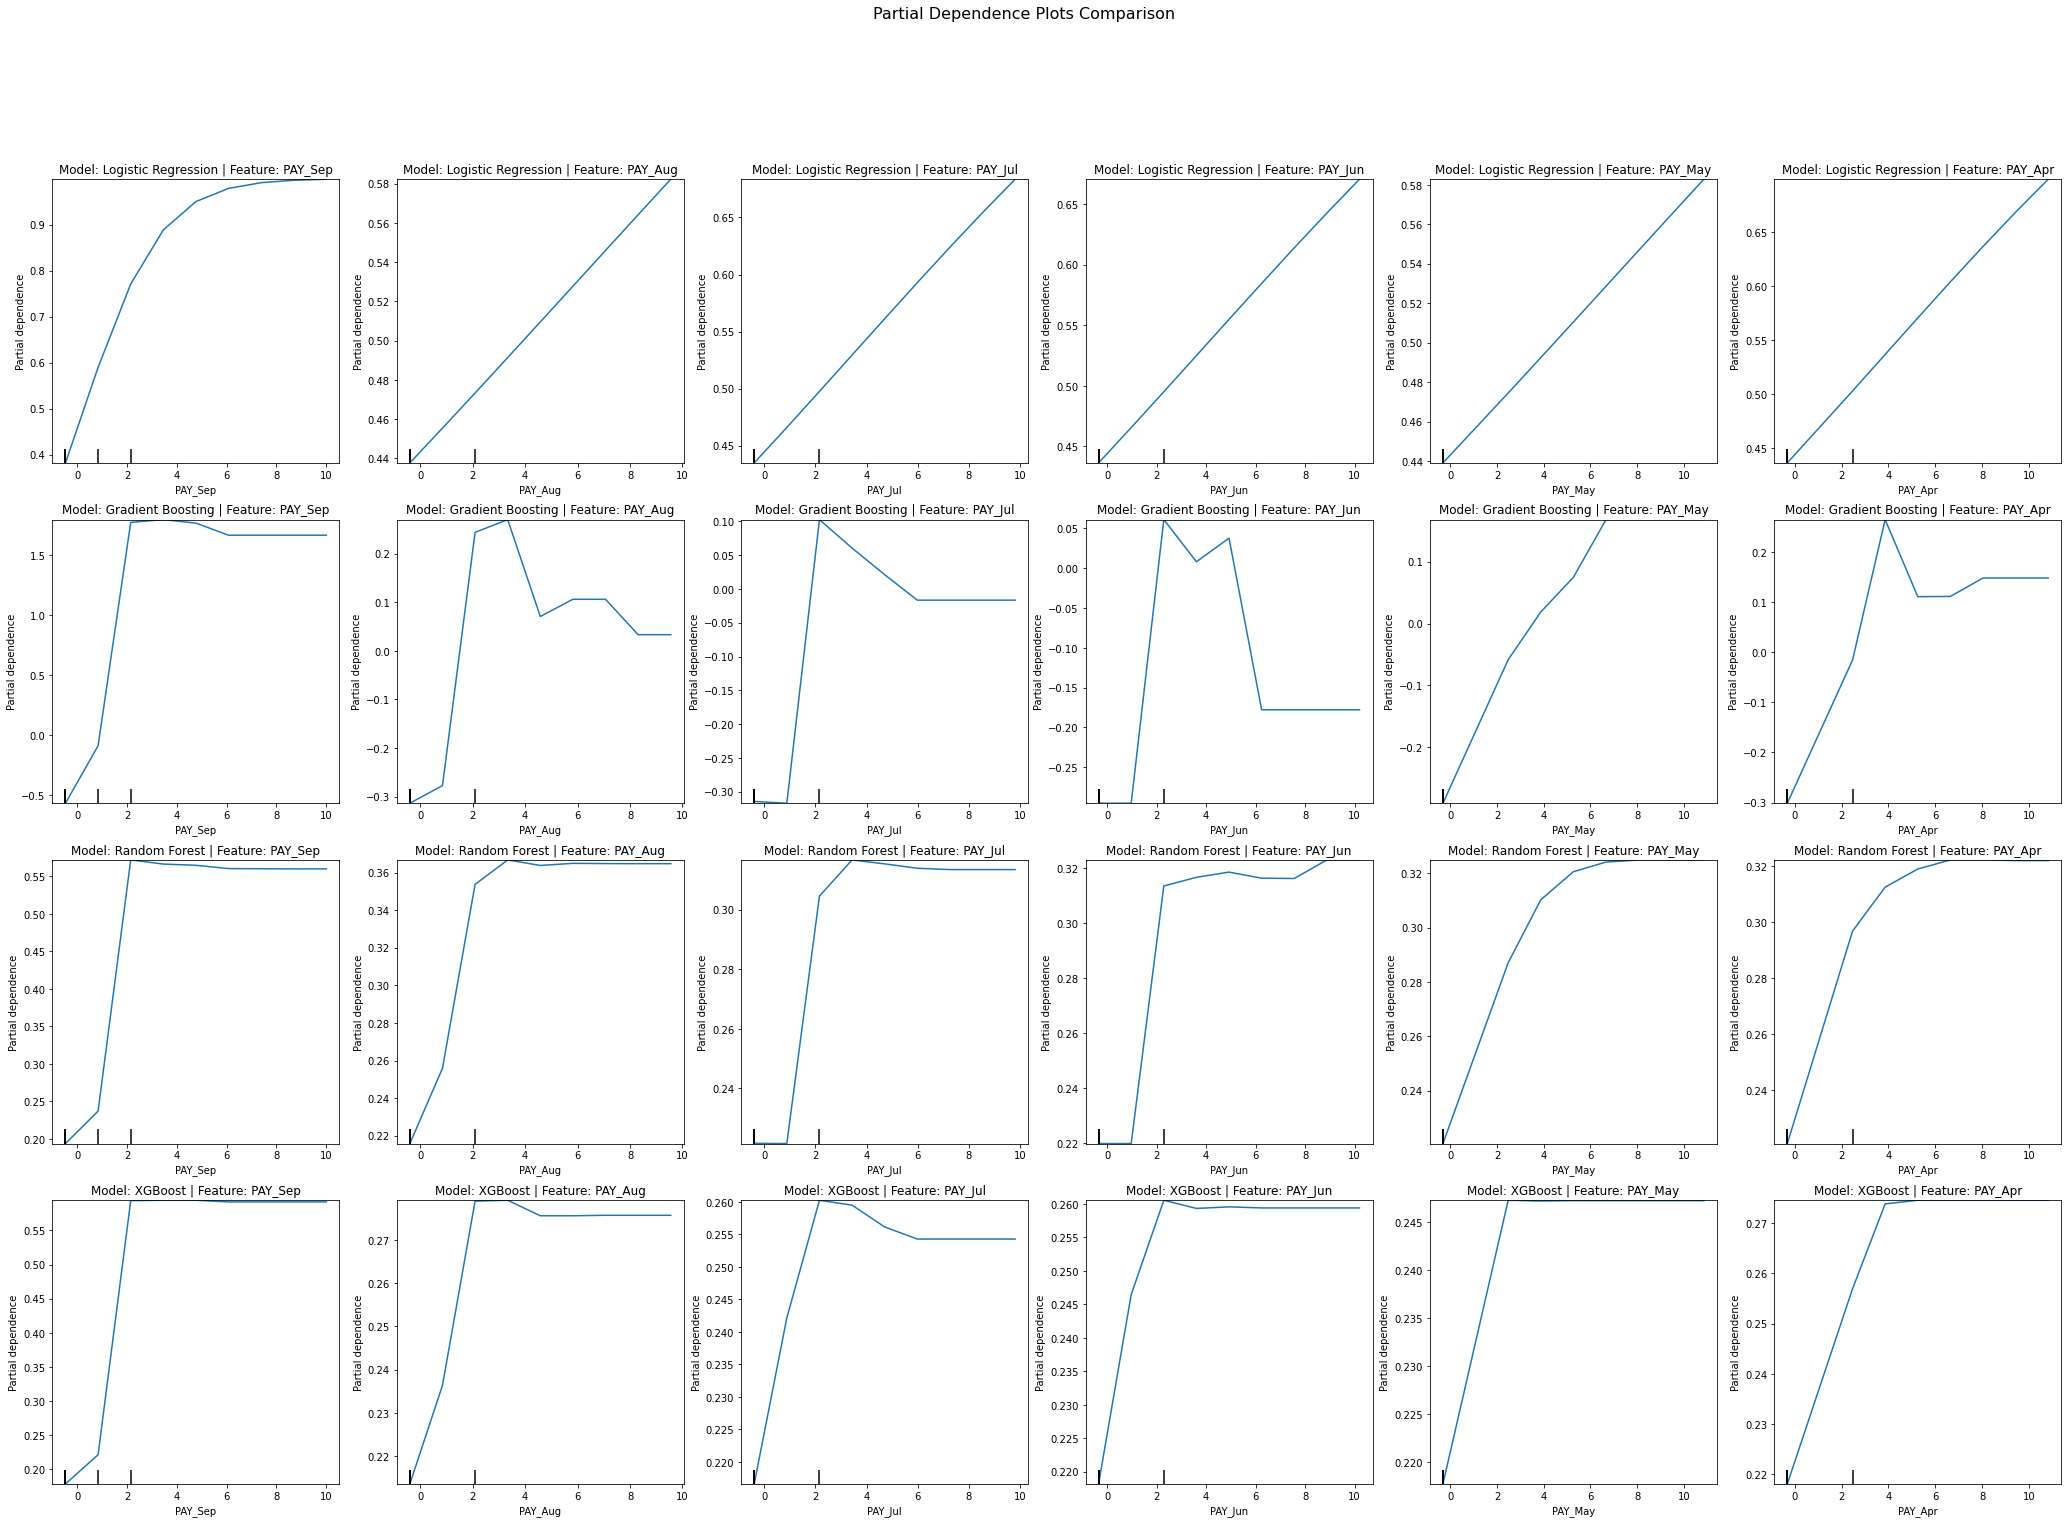

In [42]:
features = ['PAY_Sep', 'PAY_Aug', 'PAY_Jul', 'PAY_Jun', 'PAY_May', 'PAY_Apr']
models = [best_lr_model, best_gb_model, best_rf_model, best_xgb_model]
model_names = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'XGBoost']
plot_partial_dependence_comparison(models, model_names, X_train, features, df.drop(columns='default payment next month').columns)

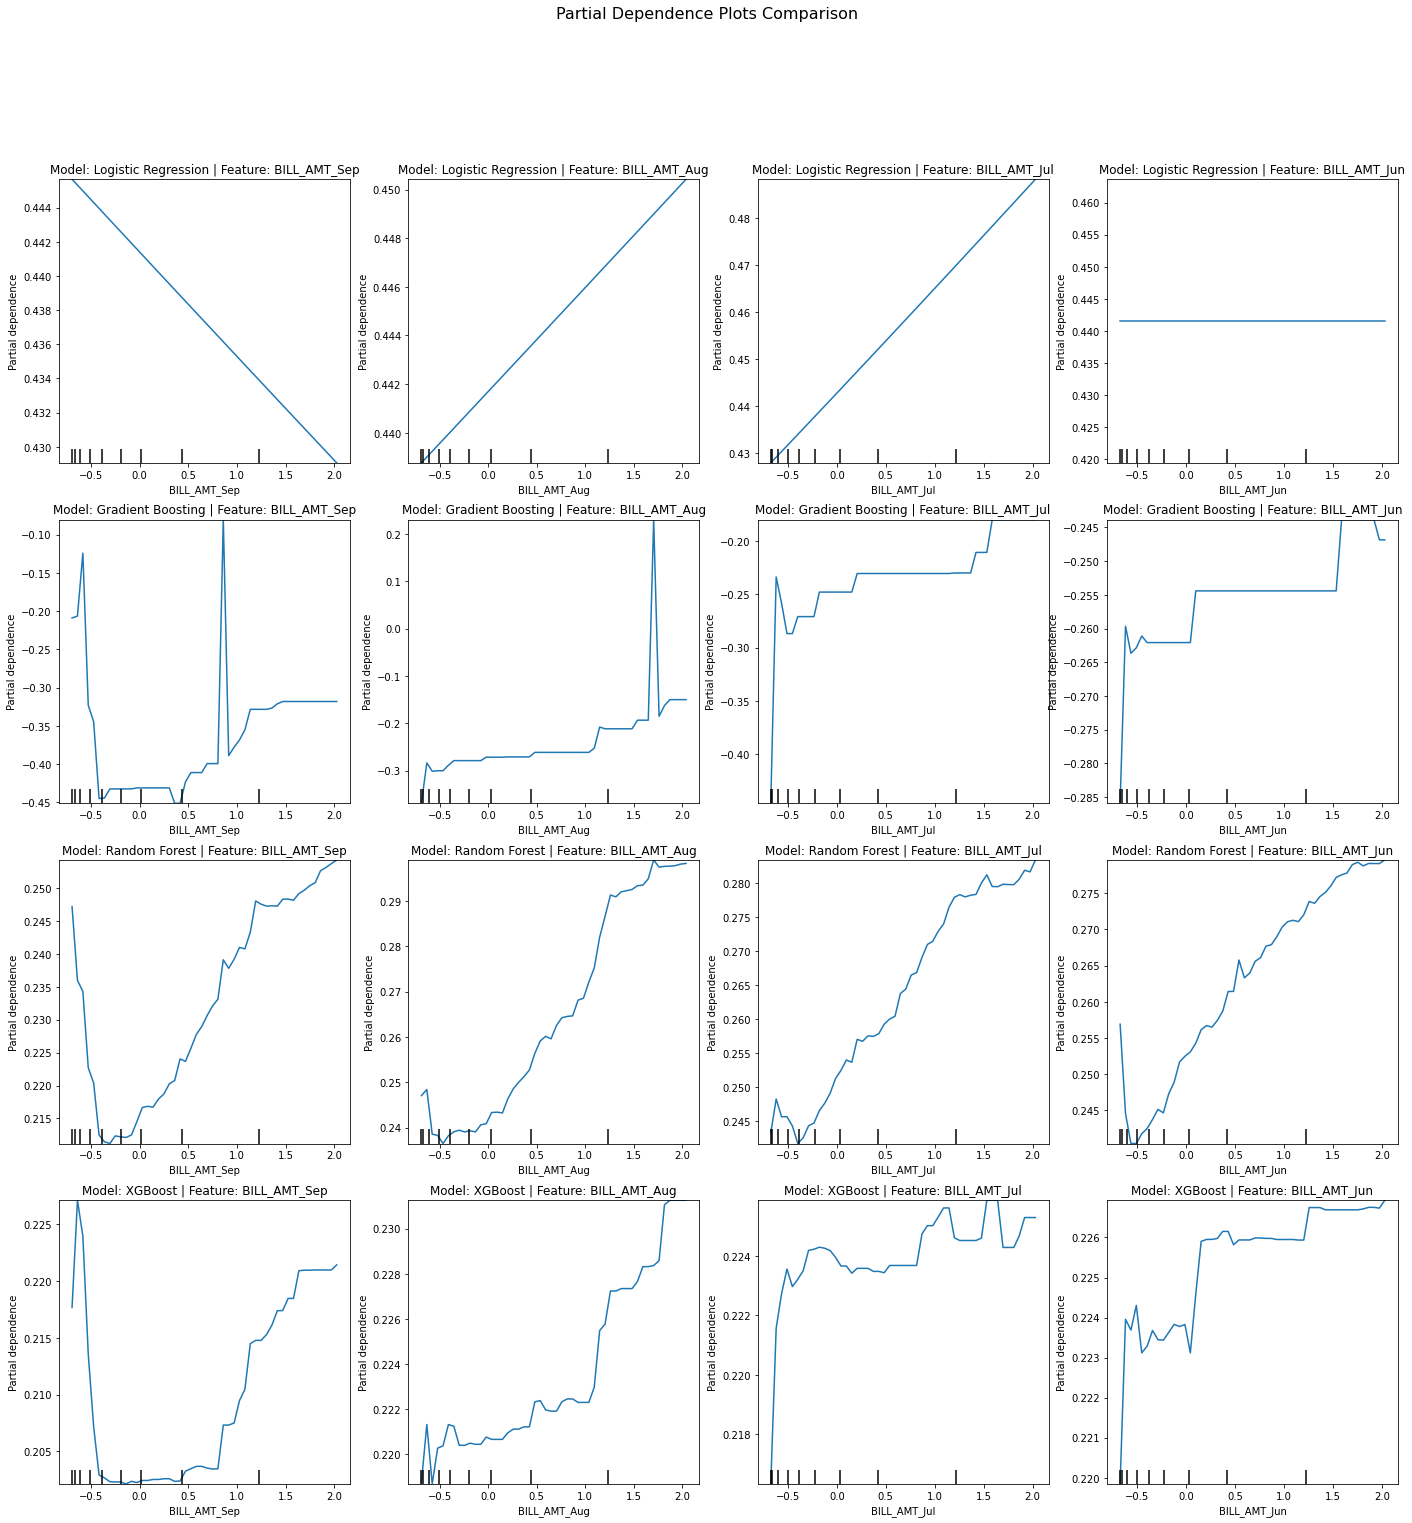

In [43]:
features = ['BILL_AMT_Sep', 'BILL_AMT_Aug', 'BILL_AMT_Jul', 'BILL_AMT_Jun']
models = [best_lr_model, best_gb_model, best_rf_model, best_xgb_model]
model_names = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'XGBoost']
plot_partial_dependence_comparison(models, model_names, X_train, features, df.drop(columns='default payment next month').columns)

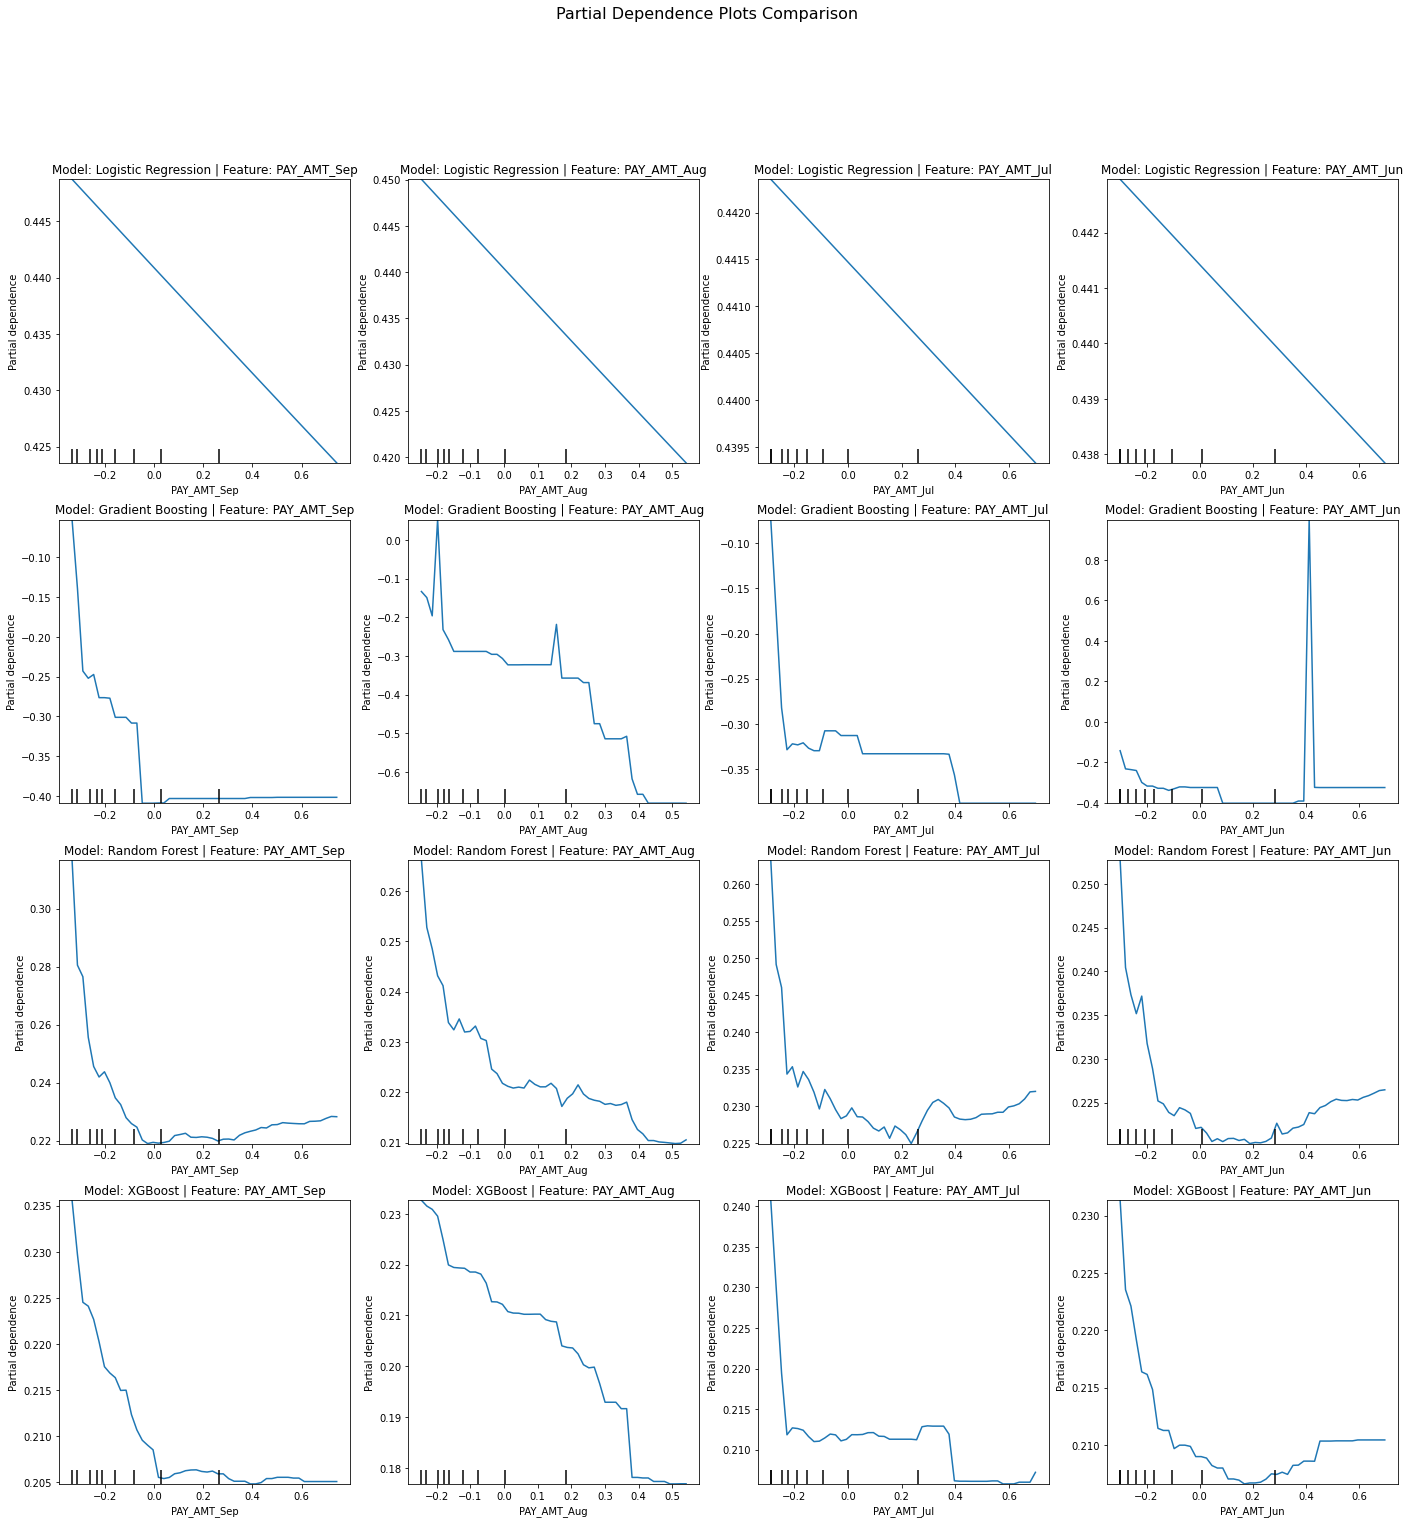

In [44]:
features = ['PAY_AMT_Sep', 'PAY_AMT_Aug', 'PAY_AMT_Jul', 'PAY_AMT_Jun']
models = [best_lr_model, best_gb_model, best_rf_model, best_xgb_model]
model_names = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'XGBoost']
plot_partial_dependence_comparison(models, model_names, X_train, features, df.drop(columns='default payment next month').columns)

#### Neural Network

In [29]:
X_train, X_test, y_train, y_test = get_train_test_data(df, target_variable='default payment next month', sampling=False, pca_n_components=None)
# convert boolean values to integers
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

Epoch 1/50
600/600 [==============================] - 1s 2ms/step - loss: 0.5231 - accuracy: 0.7751 - val_loss: 0.4822 - val_accuracy: 0.7773
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4786 - accuracy: 0.7918 - val_loss: 0.4813 - val_accuracy: 0.8104
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4650 - accuracy: 0.7990 - val_loss: 0.4915 - val_accuracy: 0.8158
Epoch 4/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4565 - accuracy: 0.8026 - val_loss: 0.4655 - val_accuracy: 0.8173
Epoch 5/50
600/600 [==============================] - 1s 1ms/step - loss: 0.4539 - accuracy: 0.8072 - val_loss: 0.4511 - val_accuracy: 0.8179
Epoch 6/50
600/600 [==============================] - 1s 1ms/step - loss: 0.4517 - accuracy: 0.8092 - val_loss: 0.4634 - val_accuracy: 0.8173
Epoch 7/50
600/600 [==============================] - 1s 1ms/step - loss: 0.4473 - accuracy: 0.8102 - val_loss: 0.4495 - val_accuracy: 0.8188
Epoch 

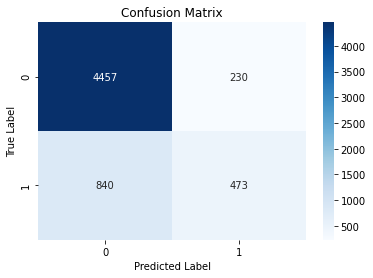

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from lime import lime_tabular


# create a neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # 输入层和第一个隐藏层
model.add(Dropout(0.5))  # Dropout层，50%的神经元被随机丢弃
model.add(Dense(64, activation='relu'))  # 第二个隐藏层
model.add(Dropout(0.5))  # Dropout层
model.add(Dense(64, activation='relu'))  # 第三个隐藏层
model.add(Dropout(0.5))  # Dropout层
model.add(Dense(32, activation='relu'))  # 第四个隐藏层
model.add(Dropout(0.5))  # Dropout层
model.add(Dense(16, activation='relu'))  # 第五个隐藏层
model.add(Dense(1, activation='sigmoid'))  # 输出层（二分类问题使用sigmoid激活函数）

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# predict
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}, Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}, F1 Score: {f1_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, zero_division=1))

# plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# use LIME to explain the model
explainer = lime_tabular.LimeTabularExplainer(X_train,
                                               feature_names=df.drop(columns='default payment next month').columns,
                                               class_names=['No', 'Yes'],
                                               mode='classification')

# define a function to predict the probability of the positive class
def predict_proba(X):
    '''
    Predict the probability of the positive class
    :param X: features
    '''
    proba = model.predict(X)
    return np.hstack((1 - proba, proba))  # return the probability of the negative class and the positive class

# select the first sample in the test set
i = 0
exp = explainer.explain_instance(X_test[i], predict_proba, num_features=10)

# visualize the explanation
exp.show_in_notebook(show_table=True)